In [ ]:
# !pip uninstall qiskit
# !pip install qiskit==0.23.0
# # !pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
# !pip install pylatexenc

In [1]:
import qiskit

# token = 'TOKEN'
# qiskit.IBMQ.save_account(token)

account = qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')
print(provider, backend)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')> ibmq_qasm_simulator


In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the CPU


In [3]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [4]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [5]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(1*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)
        

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(1*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

In [ ]:
circuit.run()

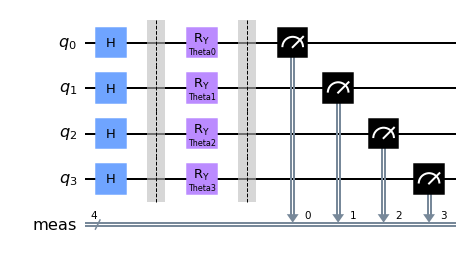

In [6]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [7]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(1*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [10]:
# import sys
# sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [8]:
from DatasetHandler import DatasetHandler
# dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
dataset_root = "/workspaces/QNN4EO/datasets/EuroSAT/2750"
handler = DatasetHandler(dataset_root)

In [9]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [10]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /workspaces/QNN4EO/datasets/EuroSAT/2750/Pasture/Pasture_264.jpg 5


In [11]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 1*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        self.fc5 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [14]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [43]:
checkpoint = torch.load('saved_models/model-rytextbook.pt')
checkpoint = torch.load('saved_models/model-real-amp-2.pt')
checkpoint = torch.load('saved_models/model-bell.pt')
checkpoint = torch.load('saved_models/model-bell-2.pt')

network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [44]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, 'saved_models/model-rytextbook-2.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: [json.exception.type_error.302] type must be array, but is number


QiskitError: 'Data for experiment "circuit-282" could not be found.'

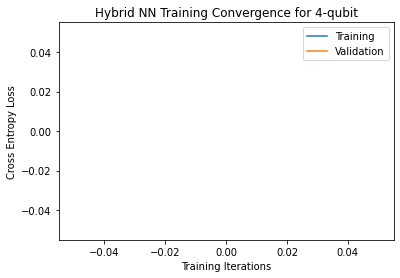

In [32]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a * np.exp(-b * x) + c

x = np.linspace(0,len(train_loss_list),len(train_loss_list))
y = func(x, 2.5, 1.3, 0.5)
yn = np.array(val_loss_list)

popt, pcov = curve_fit(func, x, yn)

plt.figure()
x1 = np.linspace(0,100+len(train_loss_list),100+len(train_loss_list))
plt.plot(x, yn, 'ko', label="Loss")
plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

ValueError: `ydata` must not be empty!

In [ ]:
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = network.predict(data).item()
  
  predictions.append(output)
  targets.append(target.item())
  
  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

In [ ]:
plt.hist(targets, bins = 10)

In [ ]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()